# Compare New York City and Toronto Neighborhoods

In [1]:
#import libraries

import pandas as pd #import Pandas
import numpy as np # import Numpy

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from IPython.display import HTML
import time
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

## 1. Creating Toronto neighborhood dataframe

In [2]:
path="Toronto_Postal_Code.xlsx" #Toronto Neighborhood details scrubbed
df = pd.read_excel(path)
df=df[df.Borough != 'Not assigned']
df.groupby(['Postal Code','Borough'])["Neighbourhood"].apply(lambda item:', '.join(item))
df=df.reset_index(drop=True)
df["Neighbourhood"].replace('Not Assigned',df["Borough"],inplace=True)

Added Latitude and Longitude information to Toronto Neighborhood information

In [3]:
filename = "http://cocl.us/Geospatial_data"
df_geo = pd.read_csv(filename)
df= pd.merge(left=df, right=df_geo, left_on='Postal Code', right_on='Postal Code')
df # final dataframe with latitude and longitude information
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(df['Borough'].unique()),len(df['Neighbourhood'].unique())))

The dataframe has 10 boroughs and 98 neighborhoods.


In [4]:
# create map of Toronto using latitude and longitude values
latitude=43.654260
longitude=-79.360636
map_toronto = folium.Map(location=[latitude,longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 2. Explore Toronto neighborhoods using the Foursquare API

In [5]:
CLIENT_ID = 'PAUJ0EV5EPWW2FJJC4I1UUO3WO2J4JMJIF33MRQDFPMGILPX' # your Foursquare ID
CLIENT_SECRET = 'XUCRHZMQ2NNDJSOMFC3PXPSNH5WPCMNJZWFXJUAHT2NOLLYN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [11]:
print(toronto_venues.shape)
#toronto_venues.groupby('Neighbourhood').count()
print('There are {} uniques categories of different venues in Toronto neighborhoods.'.format(len(toronto_venues['Venue Category'].unique())))

(2112, 7)
There are 272 uniques categories of different venues in Toronto neighborhoods.


In [12]:
toronto_venues.groupby('Neighbourhood').size()

Neighbourhood
Agincourt                                           4
Alderwood, Long Branch                             10
Bathurst Manor, Wilson Heights, Downsview North    19
Bayview Village                                     4
Bedford Park, Lawrence Manor East                  23
                                                   ..
Wexford, Maryvale                                   5
Willowdale                                         39
Woburn                                              4
Woodbine Heights                                    8
York Mills West                                     4
Length: 94, dtype: int64

## 3. List top ten venues in each Toronto neighborhood

In [15]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe and move it to the front
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#toronto_onehot.head()

toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped # Find the mean of venue by neighborhood to determine top ten venues

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.052632,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.043478,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,"Wexford, Maryvale",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
90,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.000000,0.0
91,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
92,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.125000,0.000000,0.0,0.0,0.0,0.000000,0.0


In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Gym,Pharmacy,Athletics & Sports,Pub,Sandwich Place,Dance Studio,Coffee Shop,Skating Rink,Drugstore
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Middle Eastern Restaurant,Ice Cream Shop,Sushi Restaurant,Deli / Bodega,Shopping Mall,Fried Chicken Joint,Restaurant,Diner
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sushi Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Grocery Store,Greek Restaurant,Women's Store,Café,American Restaurant,Restaurant


## 4. Apply kMeans to Toronto neighborhoods

In [18]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [19]:
# add clustering labels
toronto_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = df
toronto_merged= pd.merge(left=toronto_merged, right=toronto_neighborhoods_venues_sorted, left_on='Neighbourhood', right_on='Neighbourhood')

toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Park,Food & Drink Shop,Bus Stop,Pool,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Deli / Bodega
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Hockey Arena,Coffee Shop,French Restaurant,Portuguese Restaurant,Intersection,Financial or Legal Service,Eastern European Restaurant,Drugstore,Donut Shop,Dessert Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Pub,Park,Theater,Breakfast Spot,Café,Shoe Store,Restaurant,Chocolate Shop
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Accessories Store,Arts & Crafts Store,Furniture / Home Store,Event Space,Miscellaneous Shop,Coffee Shop,Clothing Store,Carpet Store,Boutique,Women's Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Yoga Studio,Burrito Place,Bank,Bar,Beer Bar,Italian Restaurant,Japanese Restaurant,Smoothie Shop,Sandwich Place


In [20]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Creating New York city neighborhood dataframe

In [21]:
#Download NYC neighborhood dataset
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe and load the data in the dataframe
nyc_neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
nyc_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [22]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(nyc_neighborhoods['Borough'].unique()),nyc_neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


In [23]:
# create map of New York using latitude and longitude values
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(nyc_neighborhoods['Latitude'], nyc_neighborhoods['Longitude'], nyc_neighborhoods['Borough'], nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## 6. Explore New York city neighborhoods using the Foursquare API

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
#fetch venues from Foursquare for NYC neighborhoods
VERSION = '20180604'
LIMIT = 100
nyc_venues = getNearbyVenues(names=nyc_neighborhoods['Neighborhood'],
                                   latitudes=nyc_neighborhoods['Latitude'],
                                   longitudes=nyc_neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

## 7. List top ten venues in each NYC neighborhood

In [26]:
# one hot encoding
manhattan_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe and move neighborhood column to the first column
manhattan_onehot['Neighbourhood'] = nyc_venues['Neighborhood'] 
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

#manhattan_onehot.head()

nyc_venues_grouped = manhattan_onehot.groupby('Neighbourhood').mean().reset_index()
nyc_venues_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Allerton,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Woodhaven,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.038462,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0
296,Woodlawn,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0
297,Woodrow,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.0
298,Woodside,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.012821,...,0.0,0.0,0.0,0.0,0.00,0.012821,0.00,0.0,0.0,0.0


In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nyc_venues_sorted = pd.DataFrame(columns=columns)
nyc_venues_sorted['Neighbourhood'] = nyc_venues_grouped['Neighbourhood']

for ind in np.arange(nyc_venues_grouped.shape[0]):
    nyc_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_venues_grouped.iloc[ind, :], num_top_venues)

nyc_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Intersection,Check Cashing Service,Chinese Restaurant,Martial Arts Dojo,Fast Food Restaurant,Gas Station,Pharmacy
1,Annadale,Pizza Place,Pharmacy,Deli / Bodega,American Restaurant,Cosmetics Shop,Sports Bar,Train Station,Restaurant,Diner,Bakery
2,Arden Heights,Playground,Smoke Shop,Pharmacy,Coffee Shop,Pool,Pizza Place,Fast Food Restaurant,Event Service,Event Space,Exhibit
3,Arlington,Bus Stop,Deli / Bodega,Coffee Shop,Tree,Home Service,Grocery Store,Zoo Exhibit,Field,Event Space,Exhibit
4,Arrochar,Deli / Bodega,Italian Restaurant,Bus Stop,Pizza Place,Food Truck,Supermarket,Outdoors & Recreation,Middle Eastern Restaurant,Liquor Store,Bagel Shop


## 8. Apply kMeans to NYC neighborhoods

In [28]:
# set number of clusters
kclusters = 5

nyc_venues_grouped_clustering = nyc_venues_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 4, 3, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
# add clustering labels
nyc_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge nyc_grouped with nyc_data to add latitude/longitude for each neighborhood
nyc_merged= pd.merge(left=nyc_neighborhoods, right=nyc_venues_sorted, left_on='Neighborhood', right_on='Neighbourhood')
nyc_merged 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0,Wakefield,Pharmacy,Dessert Shop,Laundromat,Ice Cream Shop,Sandwich Place,Gas Station,Donut Shop,Factory,Eye Doctor,Exhibit
1,Bronx,Co-op City,40.874294,-73.829939,3,Co-op City,Bus Station,Baseball Field,Mattress Store,Discount Store,Pizza Place,Grocery Store,Pharmacy,Bagel Shop,Fast Food Restaurant,Ice Cream Shop
2,Bronx,Eastchester,40.887556,-73.827806,0,Eastchester,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Pizza Place,Convenience Store,Metro Station,Seafood Restaurant,Fast Food Restaurant,Platform
3,Bronx,Fieldston,40.895437,-73.905643,0,Fieldston,Plaza,Athletics & Sports,River,Bus Station,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Bronx,Riverdale,40.890834,-73.912585,0,Riverdale,Park,Bus Station,Gym,Food Truck,Baseball Field,Medical Supply Store,Bank,Home Service,Playground,Plaza
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,Manhattan,Hudson Yards,40.756658,-74.000111,0,Hudson Yards,Gym / Fitness Center,Hotel,Italian Restaurant,American Restaurant,Gym,Coffee Shop,Park,Restaurant,Dog Run,Café
300,Queens,Hammels,40.587338,-73.805530,0,Hammels,Beach,Neighborhood,Dog Run,Building,Food Truck,Bus Station,Bus Stop,Gym / Fitness Center,Fast Food Restaurant,Shoe Store
301,Queens,Bayswater,40.611322,-73.765968,2,Bayswater,Park,Playground,Zoo Exhibit,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
302,Queens,Queensbridge,40.756091,-73.945631,0,Queensbridge,Hotel,Sandwich Place,Gym / Fitness Center,Hotel Bar,Roof Deck,Performing Arts Venue,Athletics & Sports,Platform,Scenic Lookout,Hotel Pool


In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighbourhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 9. Compare neighborhoods in NYC and Toronto

In [31]:
toronto_neighborhoods_venues_sorted.head() # toronto neighborhood top 10

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,0,"Alderwood, Long Branch",Pizza Place,Gym,Pharmacy,Athletics & Sports,Pub,Sandwich Place,Dance Studio,Coffee Shop,Skating Rink,Drugstore
2,0,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Middle Eastern Restaurant,Ice Cream Shop,Sushi Restaurant,Deli / Bodega,Shopping Mall,Fried Chicken Joint,Restaurant,Diner
3,0,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Yoga Studio
4,0,"Bedford Park, Lawrence Manor East",Sushi Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Grocery Store,Greek Restaurant,Women's Store,Café,American Restaurant,Restaurant


In [32]:
nyc_venues_sorted.head()

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Allerton,Pizza Place,Deli / Bodega,Supermarket,Intersection,Check Cashing Service,Chinese Restaurant,Martial Arts Dojo,Fast Food Restaurant,Gas Station,Pharmacy
1,3,Annadale,Pizza Place,Pharmacy,Deli / Bodega,American Restaurant,Cosmetics Shop,Sports Bar,Train Station,Restaurant,Diner,Bakery
2,3,Arden Heights,Playground,Smoke Shop,Pharmacy,Coffee Shop,Pool,Pizza Place,Fast Food Restaurant,Event Service,Event Space,Exhibit
3,4,Arlington,Bus Stop,Deli / Bodega,Coffee Shop,Tree,Home Service,Grocery Store,Zoo Exhibit,Field,Event Space,Exhibit
4,3,Arrochar,Deli / Bodega,Italian Restaurant,Bus Stop,Pizza Place,Food Truck,Supermarket,Outdoors & Recreation,Middle Eastern Restaurant,Liquor Store,Bagel Shop


In [33]:
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

Most Common Venue Categories in NYC

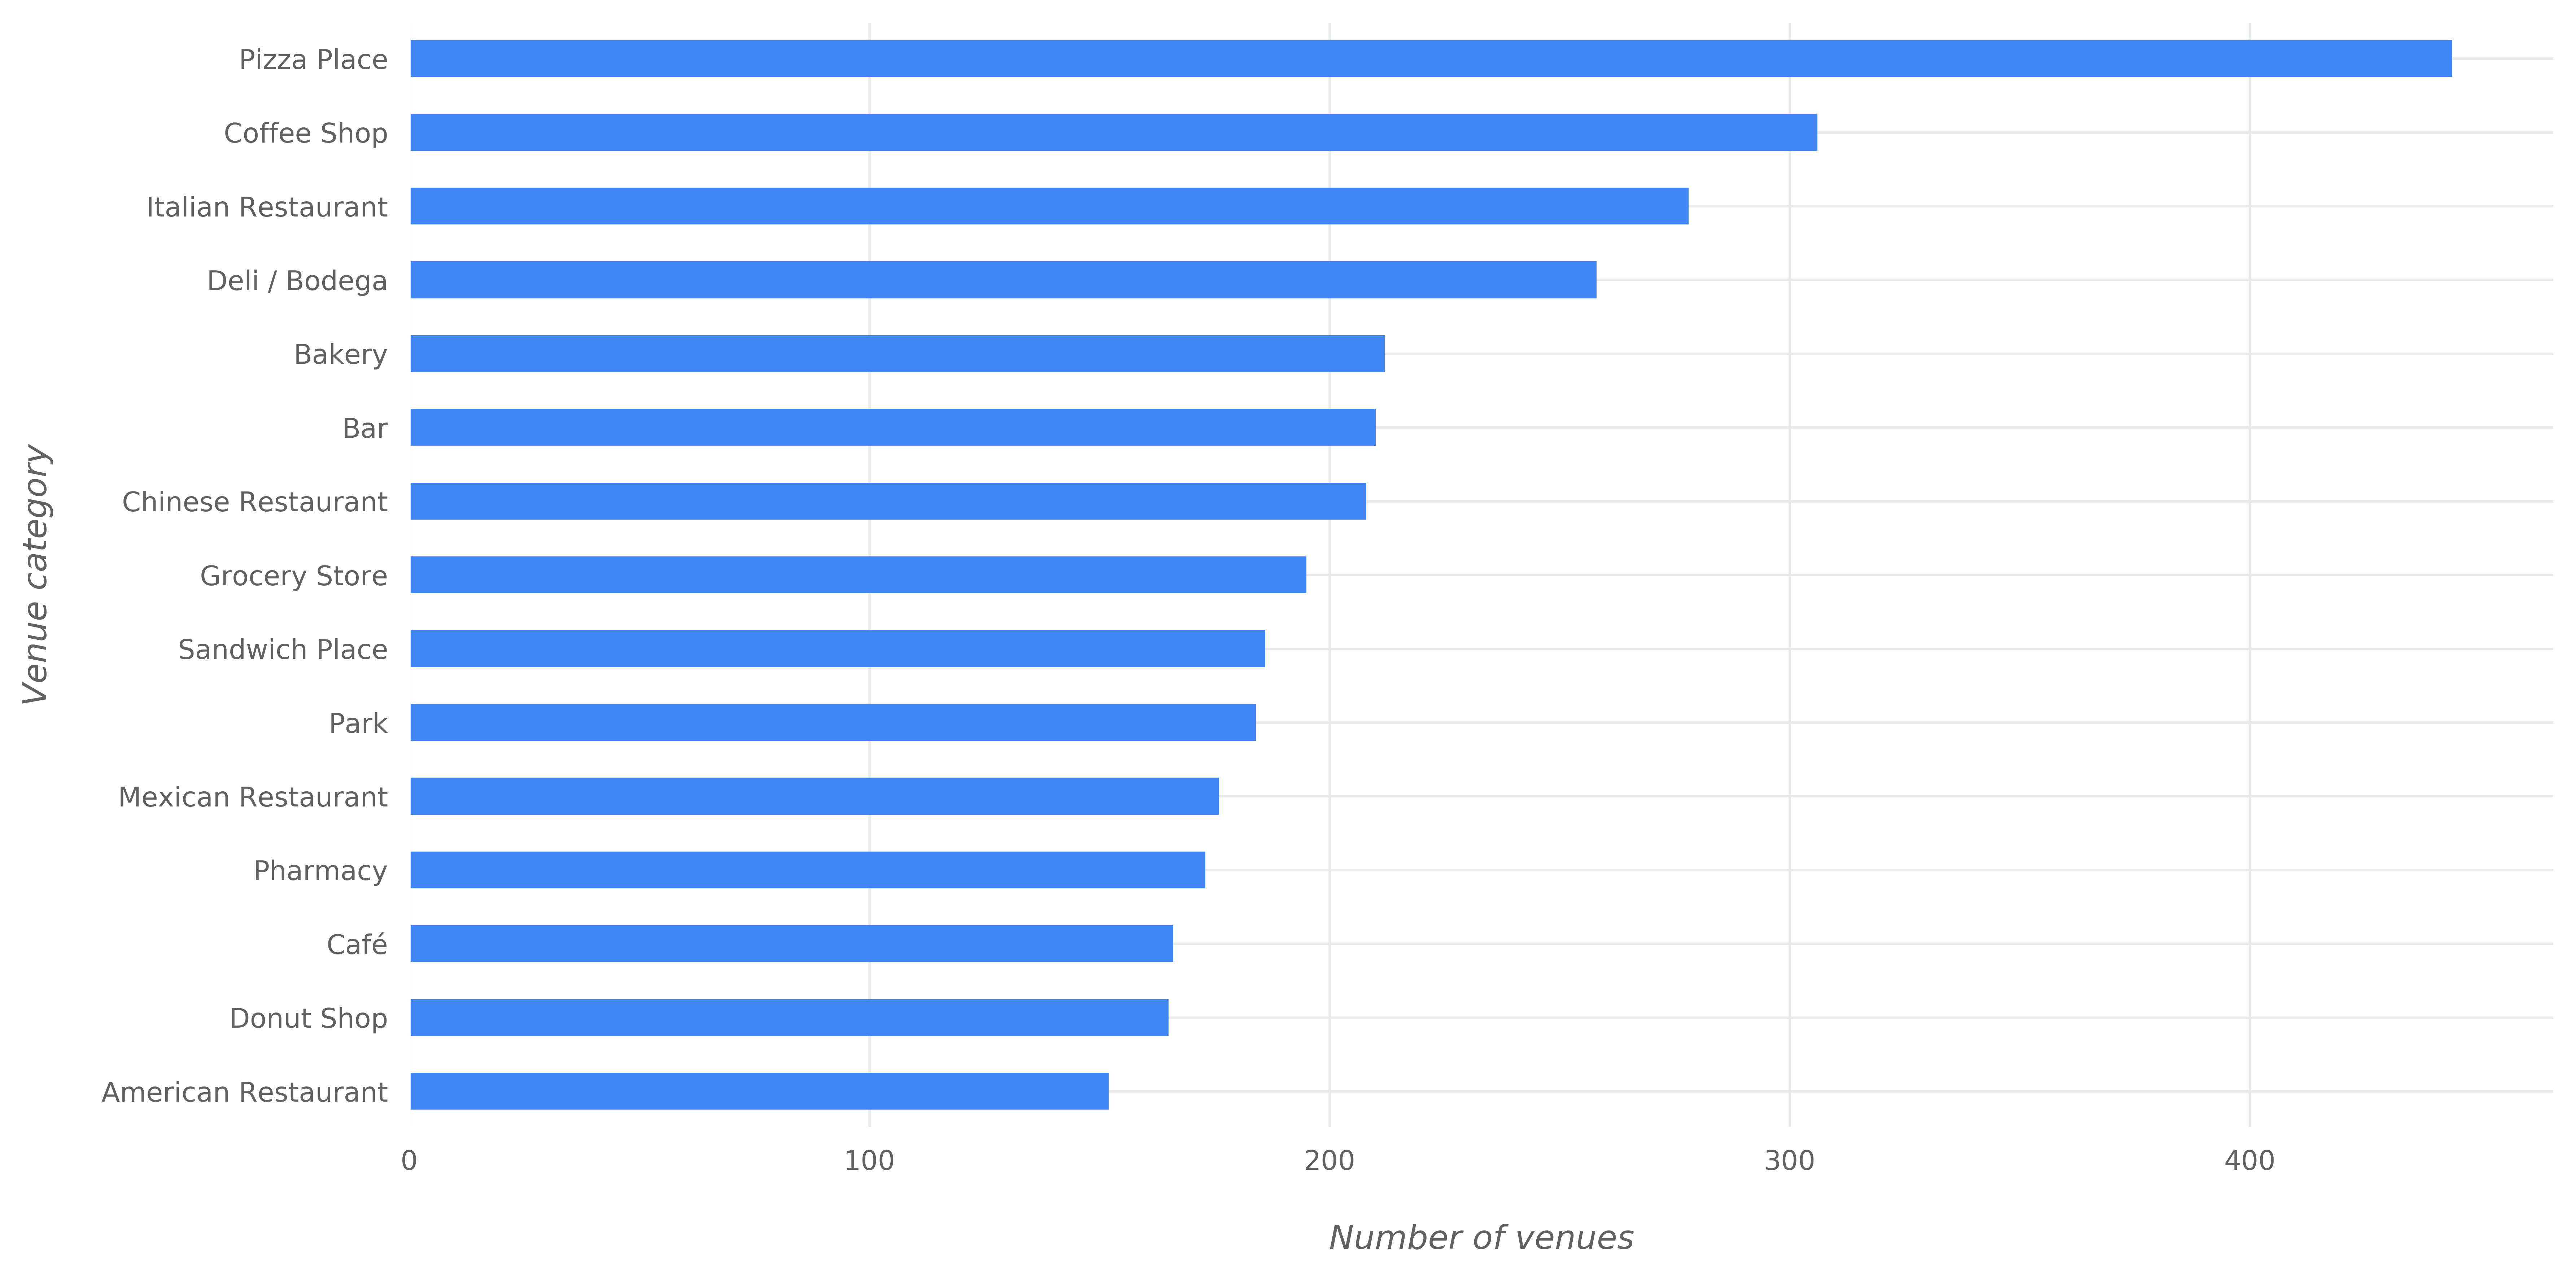

In [35]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

Most Common Venue Categories in Toronto

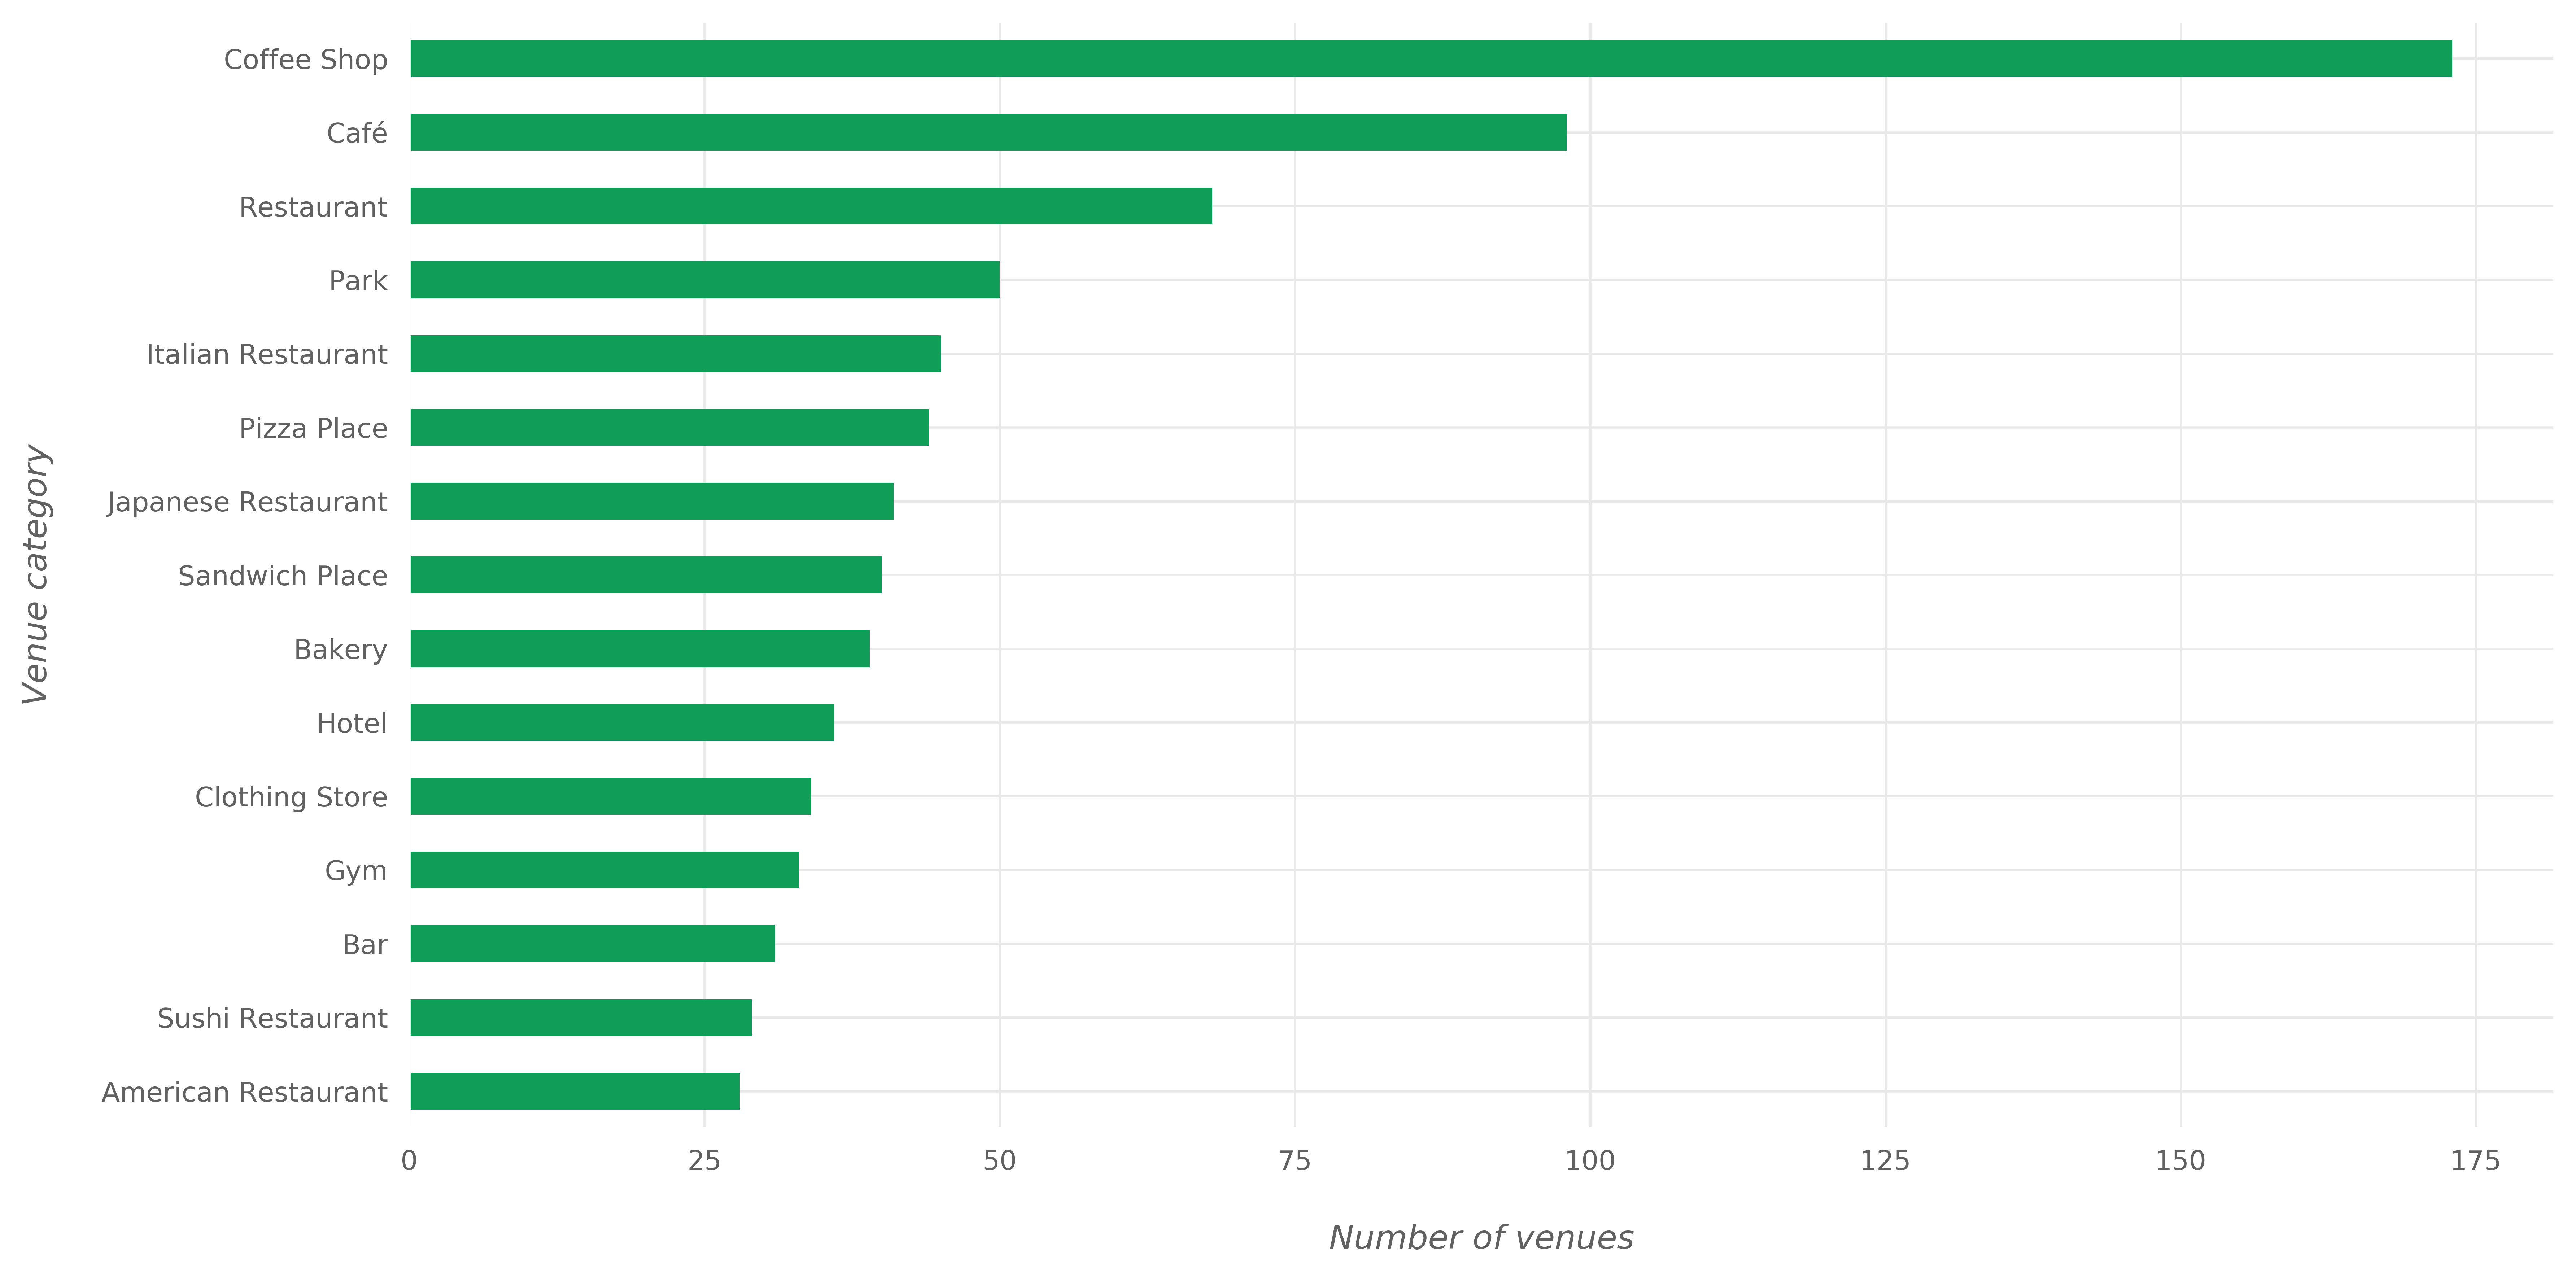

In [36]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_top_vc = toronto_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color=pc[3]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

Which venue categories exist more in NYC Neighborhoods?

300 neighborhoods in NYC


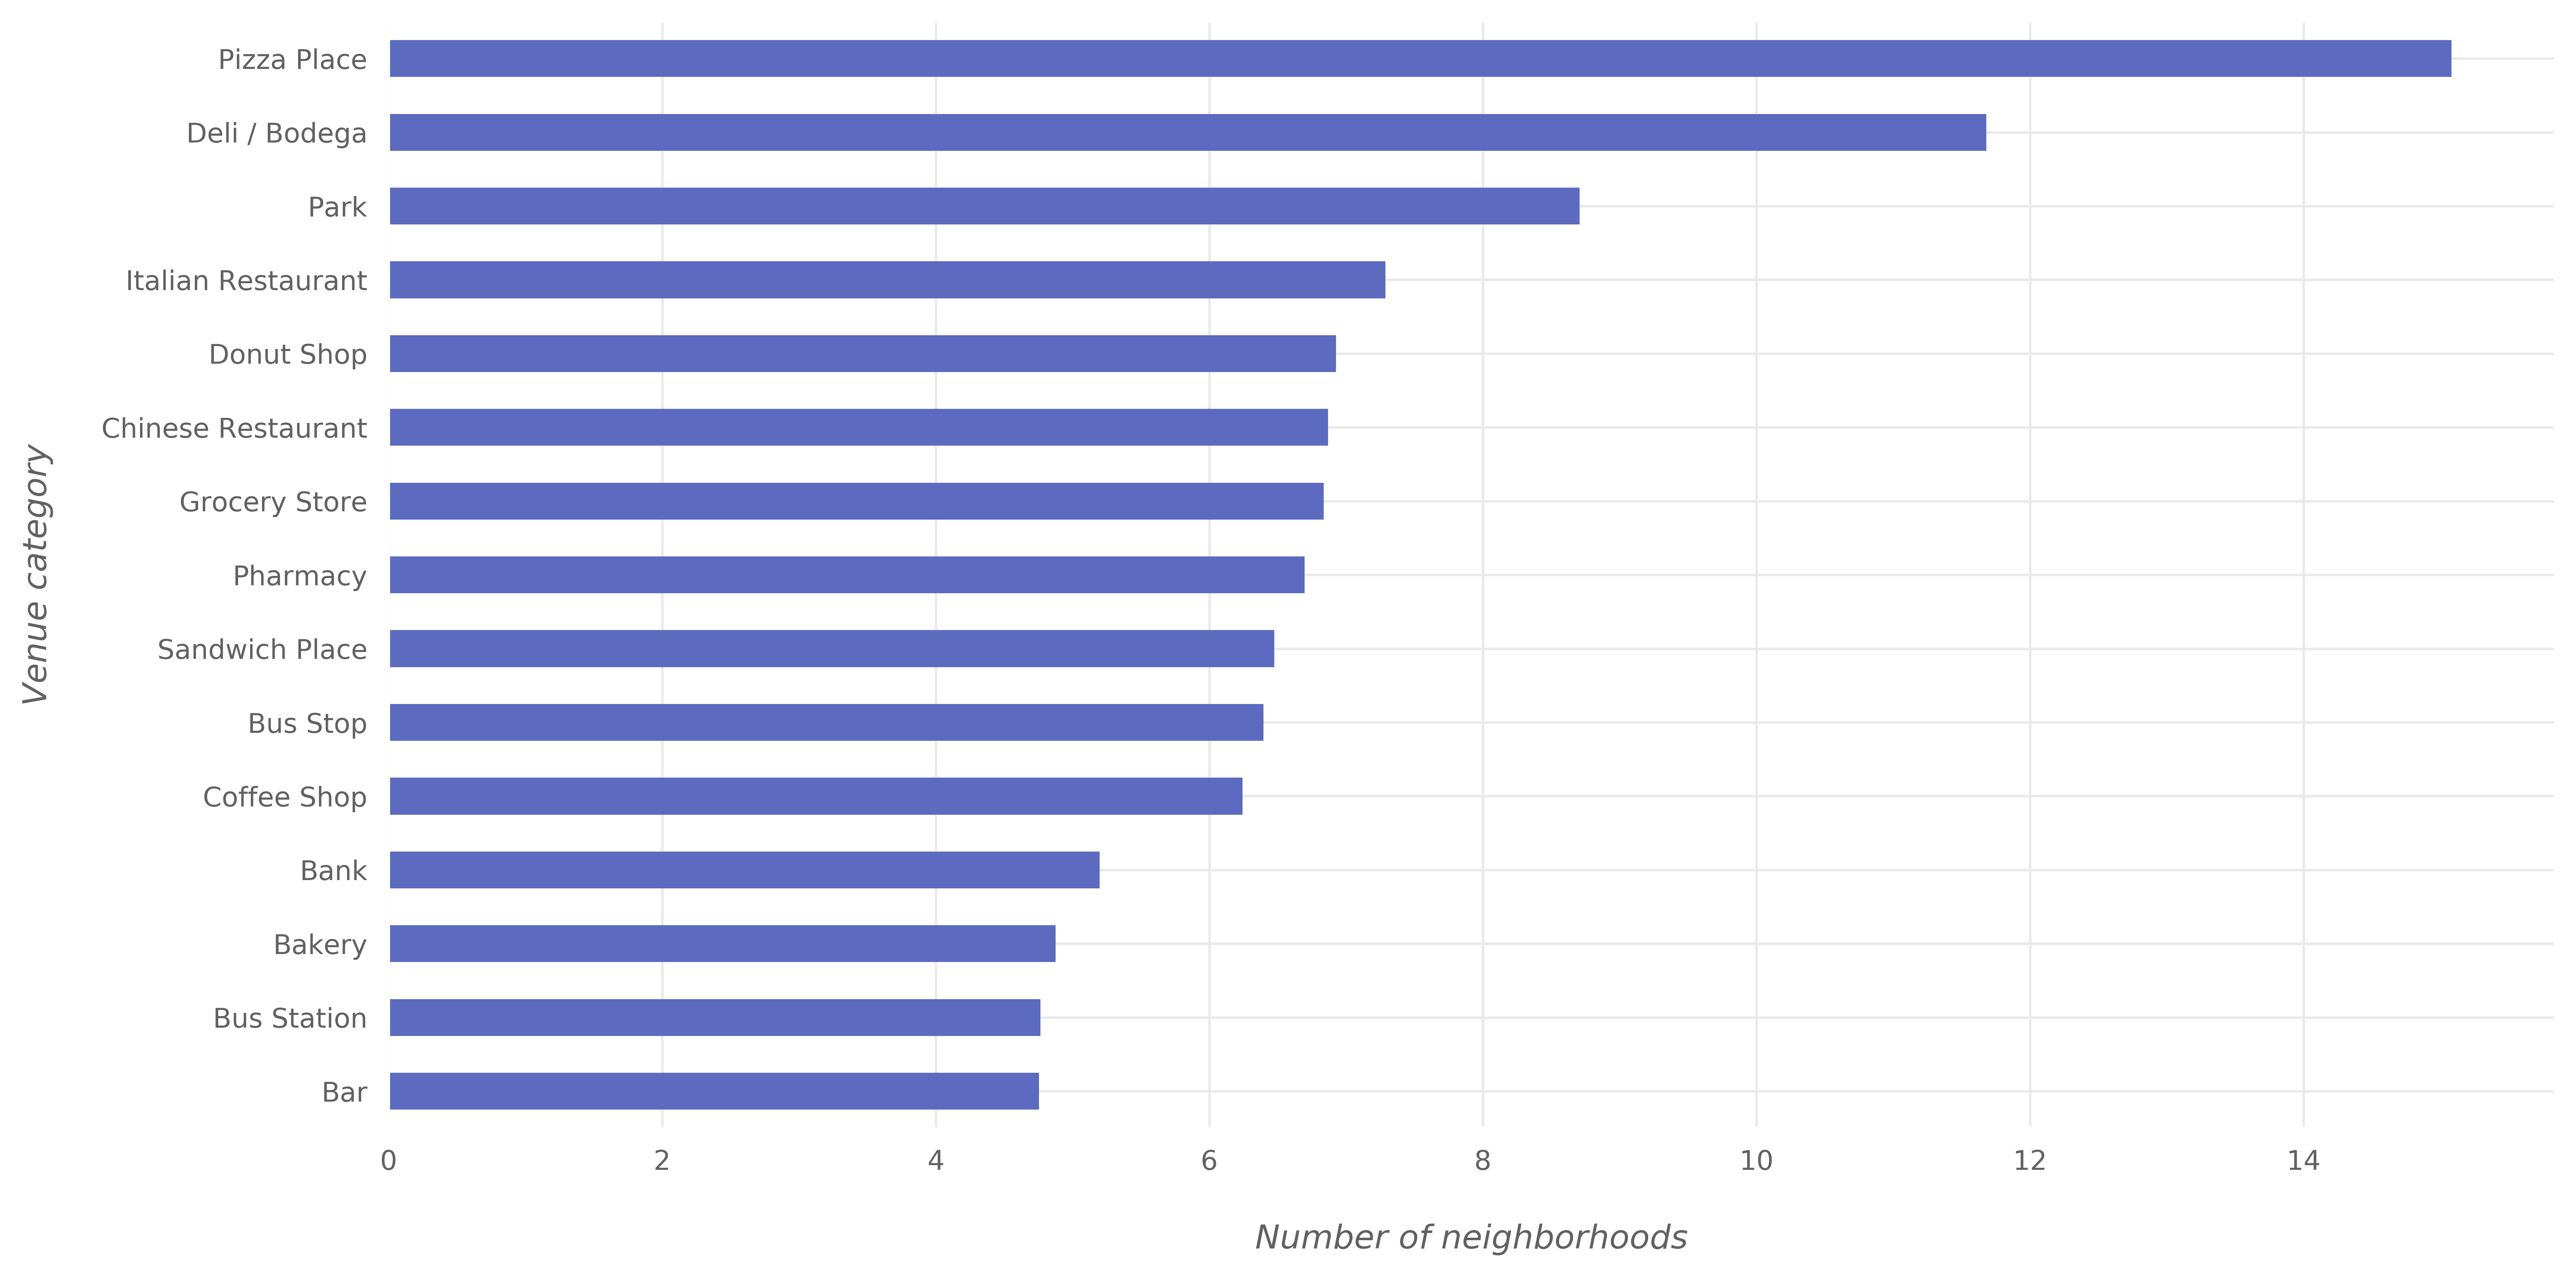

In [37]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_g = manhattan_onehot.groupby('Neighbourhood').mean().reset_index()
nyc_p = nyc_g.drop('Neighbourhood', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in NYC".format(nyc_g.shape[0]))
ax = nyc_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

Which venue categories exist more in Toronto neighborhoods

94 neighborhoods in Toronto


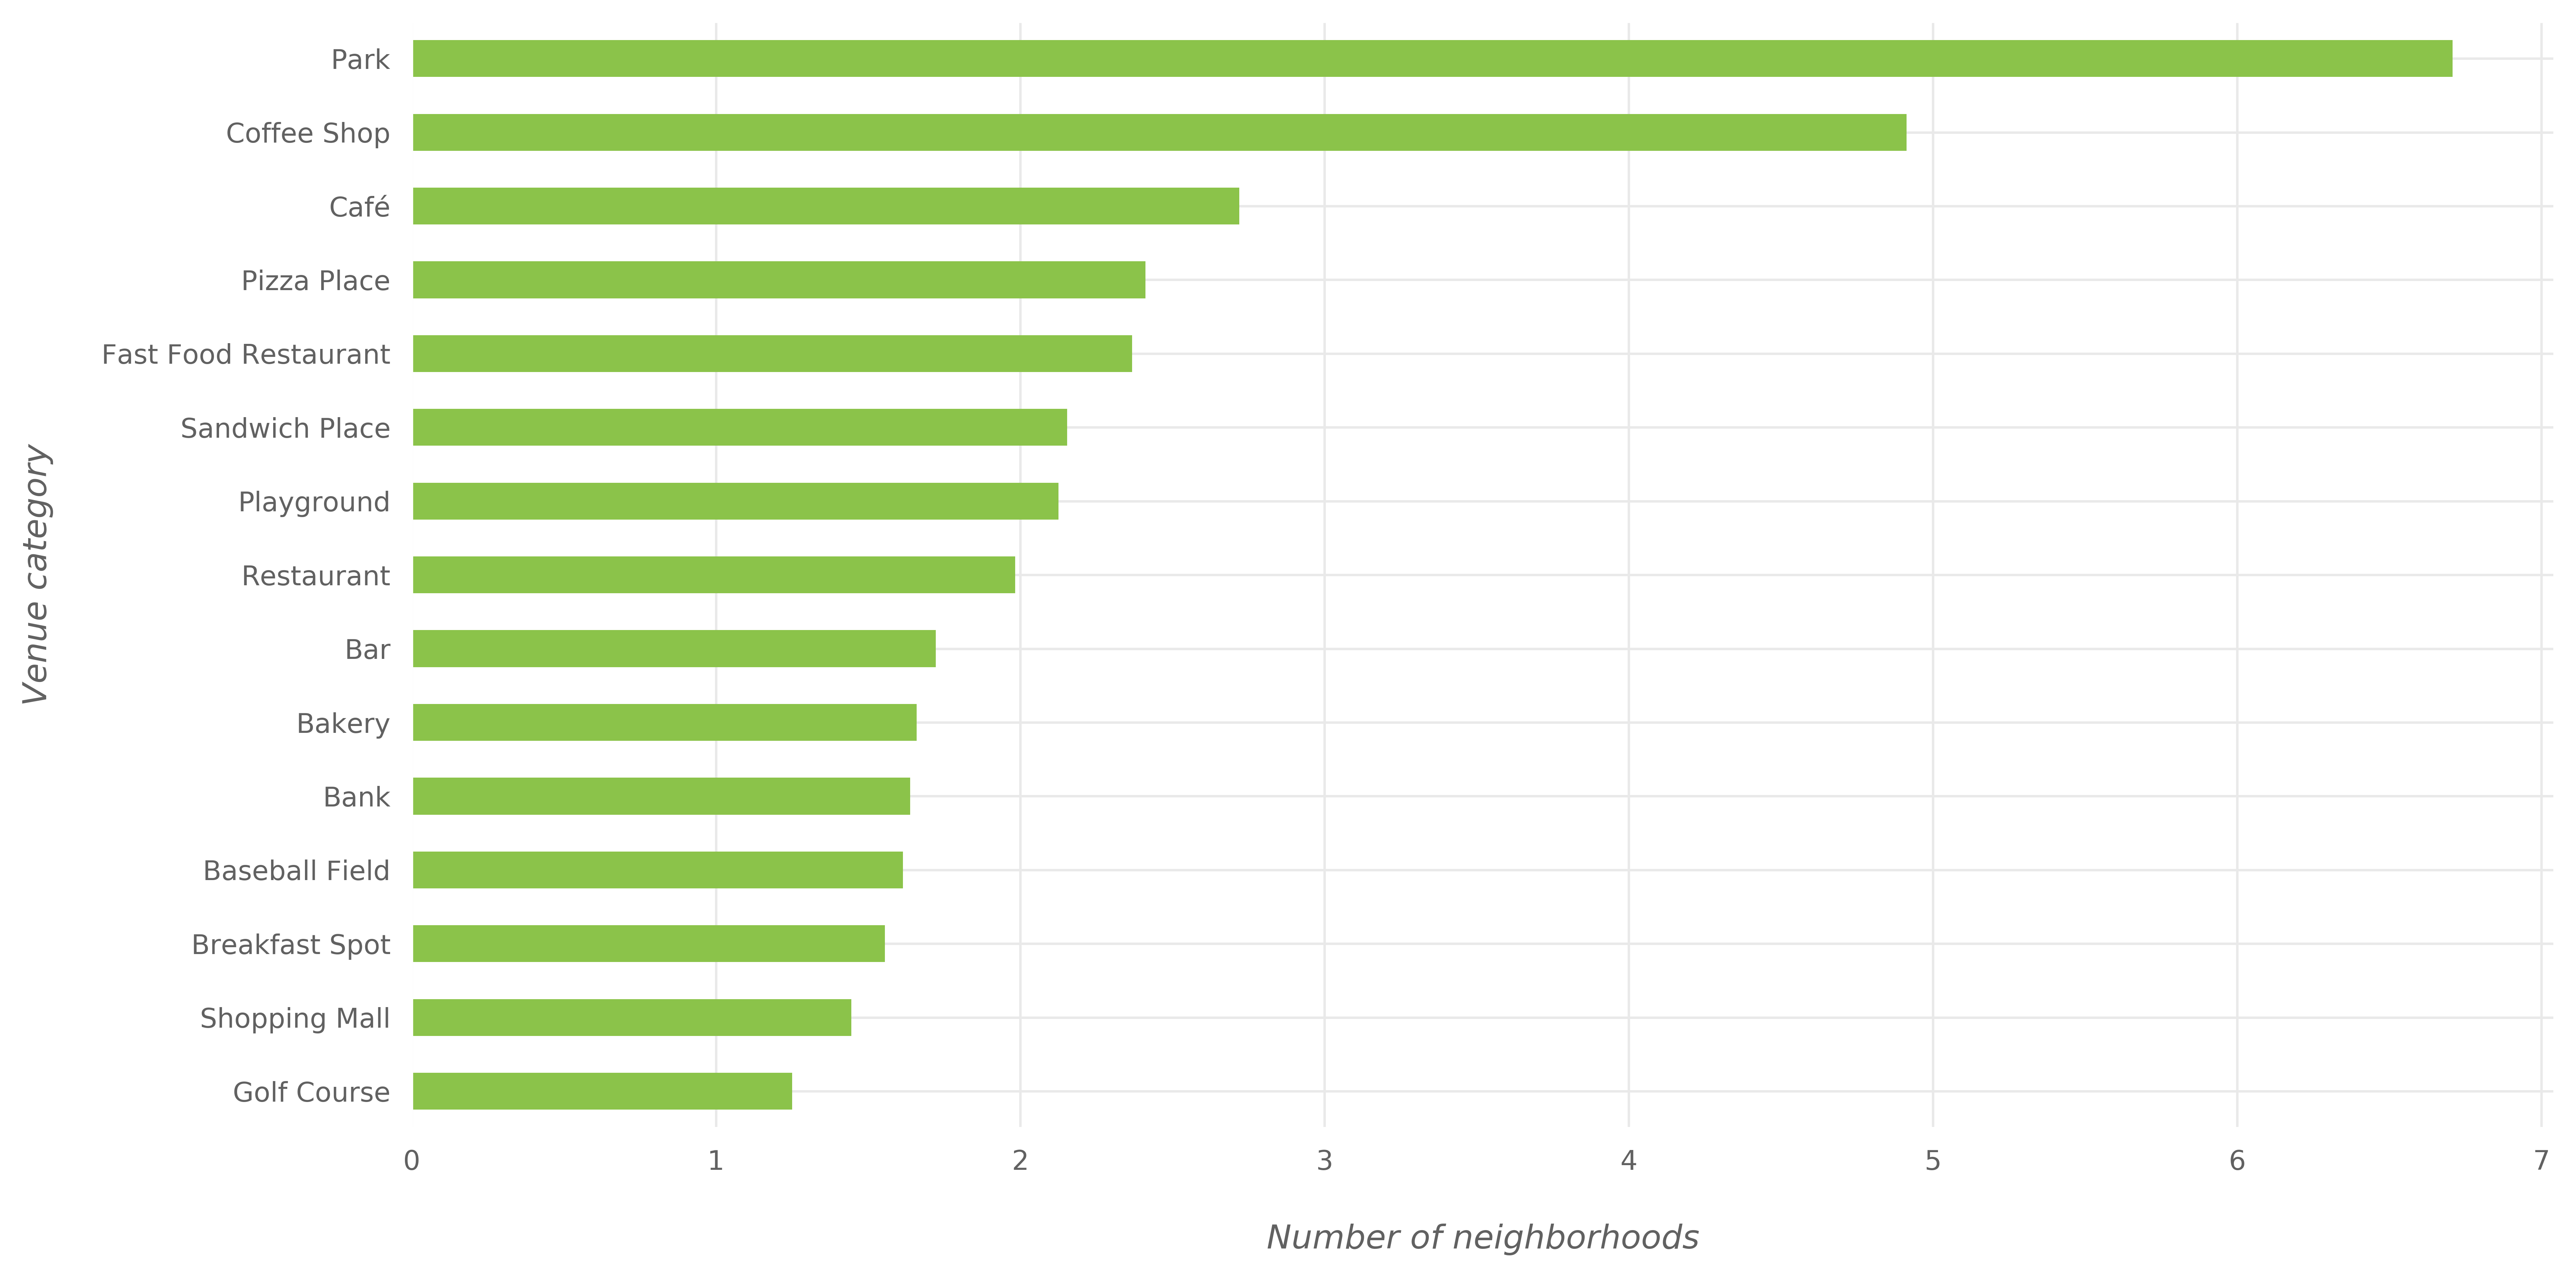

In [38]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_g = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
tor_p = tor_g.drop('Neighbourhood', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color=pc[14]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

In [39]:
clmns_nyc_only = set(nyc_venues_grouped.columns).difference(set(toronto_grouped.columns))
clmns_tor_only = set(toronto_grouped.columns).difference(set(nyc_venues_grouped.columns))

In [40]:
nyc_venues_grouped_ = nyc_venues_grouped.copy()
nyc_venues_grouped_['Neighbourhood'] = nyc_venues_grouped_['Neighbourhood'].apply(lambda x: x + '_NYC')
toronto_grouped_ = toronto_grouped.copy()
toronto_grouped_['Neighbourhood'] = toronto_grouped_['Neighbourhood'].apply(lambda x: x + '_Toronto')

for c in clmns_tor_only:
    nyc_venues_grouped_[c] = 0
for c in clmns_nyc_only:
    toronto_grouped_[c] = 0
    
all_clmns_sorted = ['Neighbourhood'] + sorted(list(nyc_venues_grouped_.drop('Neighbourhood', axis=1).columns), key=str.lower)
nyc_venues_grouped_ = nyc_venues_grouped_[all_clmns_sorted]
toronto_grouped_ = toronto_grouped_[all_clmns_sorted]
    
nyc_tor_grouped = pd.concat([nyc_venues_grouped_, toronto_grouped_]).reset_index(drop=True)

In [41]:
nyc_tor_grouped.loc[295:305,]

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
295,Woodhaven_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0
296,Woodlawn_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0
297,Woodrow_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0
298,Woodside_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.012821,0.00,0.000000,0.0,0.0
299,Yorkville_NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.01,0.030000,0.01,0.000000,0.0,0.0
300,Agincourt_Toronto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0
301,"Alderwood, Long Branch_Toronto",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0
302,"Bathurst Manor, Wilson Heights, Downsview Nort...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0
303,Bayview Village_Toronto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.000000,0.0,0.0
304,"Bedford Park, Lawrence Manor East_Toronto",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.043478,0.0,0.0


In [38]:
nyc_tor_grouped.shape

(393, 456)

In [42]:
num_top_cat=10
# obtaining the most popular categories for each neighborhood
nyc_tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_tor_neighborhoods_categories_sorted['Neighbourhood'] = nyc_tor_grouped['Neighbourhood']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_tor_grouped.iloc[ind, :], num_top_cat)

nyc_tor_neighborhoods_categories_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton_NYC,Pizza Place,Supermarket,Deli / Bodega,Intersection,Discount Store,Cosmetics Shop,Fast Food Restaurant,Spanish Restaurant,Spa,Fried Chicken Joint
1,Annadale_NYC,Pizza Place,Cosmetics Shop,American Restaurant,Pharmacy,Train Station,Diner,Deli / Bodega,Restaurant,Bakery,Sports Bar
2,Arden Heights_NYC,Pizza Place,Smoke Shop,Pharmacy,Pool,Coffee Shop,Playground,Exhibit,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
3,Arlington_NYC,Bus Stop,Home Service,Grocery Store,Deli / Bodega,Coffee Shop,Tree,Zoo Exhibit,Event Service,Event Space,Ethiopian Restaurant
4,Arrochar_NYC,Deli / Bodega,Pizza Place,Bus Stop,Italian Restaurant,Food Truck,Athletics & Sports,Polish Restaurant,Sandwich Place,Outdoors & Recreation,Supermarket


Most Common Venue Categories in both NYC and Toronto

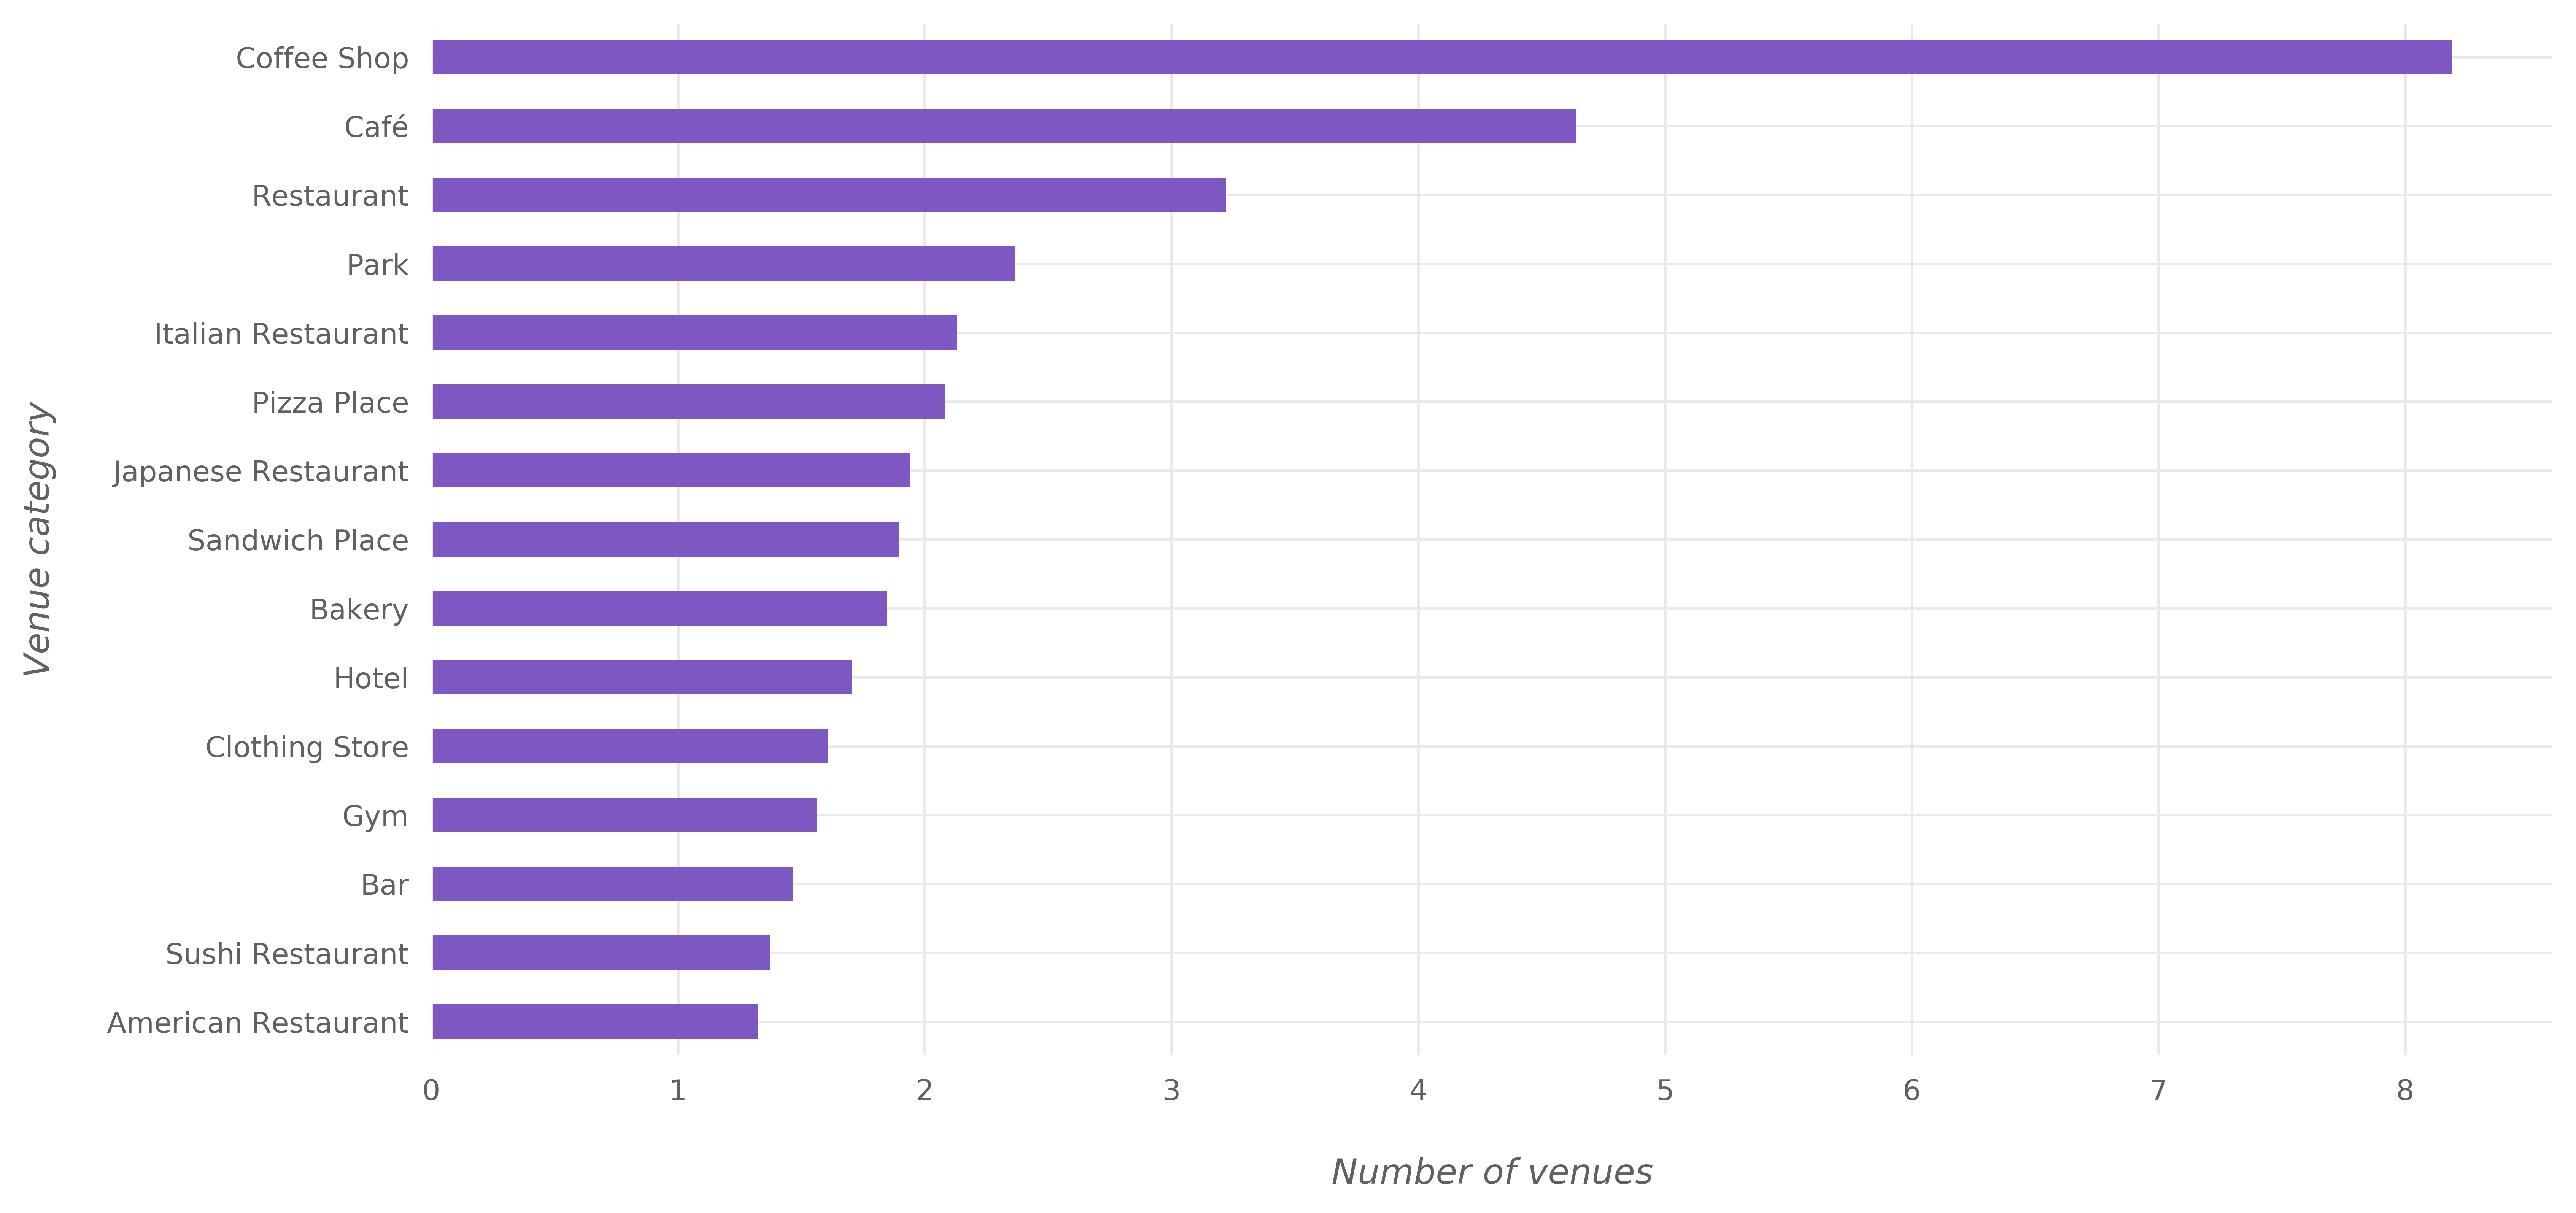

In [43]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_tor_top_vc = pd.concat([nyc_venues_grouped, toronto_venues])['Venue Category'].value_counts(normalize=True) * 100
ax = nyc_tor_top_vc.head(15).plot(kind='barh', color=pc[12]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
fig.savefig('most-common-ven-nyc-tor.png', dpi=300)

## 10. NYC and Toronto merged data Clustering

In [44]:
# the number of clusters
kclusters = 5

nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 3, 2, 2, 4, 2, 4, 2], dtype=int32)

In [45]:
# add clustering labels
nyc_tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# nyc_tor_merged = nyc_tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
# tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighbourhood')

nyc_tor_merged.iloc[300:310] # check the last columns!

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,,,,,,,,,,,
Agincourt_Toronto,4,Breakfast Spot,Lounge,Skating Rink,Latin American Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
"Alderwood, Long Branch_Toronto",2,Pizza Place,Pub,Dance Studio,Skating Rink,Pharmacy,Athletics & Sports,Coffee Shop,Sandwich Place,Gym,Farmers Market
"Bathurst Manor, Wilson Heights, Downsview North_Toronto",2,Bank,Coffee Shop,Ice Cream Shop,Deli / Bodega,Supermarket,Fried Chicken Joint,Sushi Restaurant,Middle Eastern Restaurant,Gas Station,Shopping Mall
Bayview Village_Toronto,4,Bank,Japanese Restaurant,Café,Chinese Restaurant,Zoo Exhibit,Factory,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant
"Bedford Park, Lawrence Manor East_Toronto",4,Coffee Shop,Italian Restaurant,Sushi Restaurant,Sandwich Place,Pharmacy,Café,Restaurant,Juice Bar,Butcher,Pizza Place
Berczy Park_Toronto,4,Coffee Shop,Cocktail Bar,Beer Bar,Bakery,Café,Restaurant,Seafood Restaurant,Cheese Shop,Steakhouse,Bistro
"Birch Cliff, Cliffside West_Toronto",4,General Entertainment,Skating Rink,College Stadium,Café,Zoo Exhibit,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
"Brockton, Parkdale Village, Exhibition Place_Toronto",4,Café,Breakfast Spot,Nightclub,Coffee Shop,Intersection,Restaurant,Stadium,Burrito Place,Climbing Gym,Pet Store
Business reply mail Processing Centre_Toronto,4,Park,Spa,Garden Center,Garden,Smoke Shop,Auto Workshop,Pizza Place,Restaurant,Light Rail Station,Skate Park


In [47]:
nyc_tor_merged.iloc[295:305] # check the last columns!

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,,,,,,,,,,,
Woodhaven_NYC,2,Deli / Bodega,Bank,Pharmacy,Spanish Restaurant,Arepa Restaurant,Liquor Store,Thai Restaurant,Donut Shop,Bagel Shop,Park
Woodlawn_NYC,2,Deli / Bodega,Pizza Place,Pub,Playground,Grocery Store,Park,Donut Shop,Trail,Liquor Store,Train Station
Woodrow_NYC,2,Pharmacy,Bank,Juice Bar,Martial Arts Dojo,Liquor Store,Bakery,Bagel Shop,Gift Shop,Coffee Shop,Donut Shop
Woodside_NYC,4,Grocery Store,Thai Restaurant,Latin American Restaurant,Bakery,Bar,Filipino Restaurant,Donut Shop,Pub,American Restaurant,Pharmacy
Yorkville_NYC,4,Coffee Shop,Italian Restaurant,Gym,Deli / Bodega,Bar,Sushi Restaurant,Mexican Restaurant,Japanese Restaurant,Wine Shop,Diner
Agincourt_Toronto,4,Breakfast Spot,Lounge,Skating Rink,Latin American Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
"Alderwood, Long Branch_Toronto",2,Pizza Place,Pub,Dance Studio,Skating Rink,Pharmacy,Athletics & Sports,Coffee Shop,Sandwich Place,Gym,Farmers Market
"Bathurst Manor, Wilson Heights, Downsview North_Toronto",2,Bank,Coffee Shop,Ice Cream Shop,Deli / Bodega,Supermarket,Fried Chicken Joint,Sushi Restaurant,Middle Eastern Restaurant,Gas Station,Shopping Mall
Bayview Village_Toronto,4,Bank,Japanese Restaurant,Café,Chinese Restaurant,Zoo Exhibit,Factory,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant


## 11. Examining clusters
#### Let's see the neighborhoods in each of the five clusters:

In [48]:
c1 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 0, :]
print(c1.shape)
c1.tail()

(1, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,,,,,,,,,,,
Humber Summit_Toronto,0,Shopping Mall,Factory,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant


In [49]:
c2 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, :]
print(c2.shape)
c2.tail()

(11, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,,,,,,,,,,,
"Milliken, Agincourt North, Steeles East, L'Amoreaux East_Toronto",1,Playground,Park,Zoo Exhibit,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
Rosedale_Toronto,1,Park,Trail,Playground,Zoo Exhibit,Eye Doctor,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant
"The Kingsway, Montgomery Road, Old Mill North_Toronto",1,Park,River,Pool,Zoo Exhibit,Factory,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant
Weston_Toronto,1,Park,Zoo Exhibit,Duty-free Shop,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
York Mills West_Toronto,1,Park,Convenience Store,Bank,Zoo Exhibit,Falafel Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant


In [50]:
c3 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 2, :]
print(c3.shape)
c3.tail()

(202, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,,,,,,,,,,,
Scarborough Village_Toronto,2,Playground,Zoo Exhibit,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
"South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens_Toronto",2,Grocery Store,Pizza Place,Fried Chicken Joint,Beer Store,Pharmacy,Fast Food Restaurant,Sandwich Place,Liquor Store,Electronics Store,Event Space
"Steeles West, L'Amoreaux West_Toronto",2,Chinese Restaurant,Fast Food Restaurant,Bank,Breakfast Spot,Sandwich Place,Coffee Shop,Pizza Place,Pharmacy,Thrift / Vintage Store,Nail Salon
Thorncliffe Park_Toronto,2,Indian Restaurant,Liquor Store,Gym,Pharmacy,Gas Station,Discount Store,Restaurant,Pizza Place,Supermarket,Sandwich Place
Westmount_Toronto,2,Pizza Place,Intersection,Middle Eastern Restaurant,Coffee Shop,Sandwich Place,Discount Store,Chinese Restaurant,Cycle Studio,Czech Restaurant,Electronics Store


In [51]:
c4 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 3, :]
print(c4.shape)
c4.tail()

(11, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,,,,,,,,,,,
Park Hill_NYC,3,Bus Stop,Gym / Fitness Center,Athletics & Sports,Hotel,Coffee Shop,Zoo Exhibit,Eye Doctor,Egyptian Restaurant,Electronics Store,Empanada Restaurant
Randall Manor_NYC,3,Bus Stop,Deli / Bodega,Pizza Place,Bagel Shop,Playground,Park,Fish & Chips Shop,Eye Doctor,Eastern European Restaurant,Egyptian Restaurant
Sandy Ground_NYC,3,Bus Stop,Intersection,Market,Falafel Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
Willowbrook_NYC,3,Bus Stop,Pizza Place,Deli / Bodega,Spa,Zoo Exhibit,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
Parkwoods_Toronto,3,Food & Drink Shop,Bus Stop,Park,Pool,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant


In [52]:
c5 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 4, :]
print(c5.shape)
c5.tail()

(169, 11)


,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighbourhood,,,,,,,,,,,
"West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale_Toronto",4,Golf Course,Zoo Exhibit,Factory,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
"Wexford, Maryvale_Toronto",4,Breakfast Spot,Sandwich Place,Shopping Mall,Auto Garage,Bakery,Flea Market,Fish Market,Food & Drink Shop,Eastern European Restaurant,Food
Willowdale_Toronto,4,Pizza Place,Ramen Restaurant,Coffee Shop,Café,Sandwich Place,Grocery Store,Sushi Restaurant,Arts & Crafts Store,Restaurant,Discount Store
Woburn_Toronto,4,Coffee Shop,Korean Restaurant,Indian Restaurant,Zoo Exhibit,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service
Woodbine Heights_Toronto,4,Skating Rink,Cosmetics Shop,Park,Beer Store,Video Store,Curling Ice,Pharmacy,Entertainment Service,Event Service,Ethiopian Restaurant


In [53]:
clust_cats = []
clusters = [c1, c2, c3, c4, c5]
for i, clus in enumerate(clusters):
    clust_cats.append([])
    for n in clus.index.values:
        if n.endswith('NYC'):
            nn = n[:-4]
            clust_cats[i].extend(list(nyc_venues[nyc_venues['Neighborhood'] == nn]['Venue Category'].values))
        else:
            nn = n[:-8]
            clust_cats[i].extend(list(toronto_venues[toronto_venues['Neighbourhood'] == nn]['Venue Category'].values))
    clust_cats[i] = pd.Series(clust_cats[i]).value_counts(normalize=True) * 100

In [54]:
tbl_bck = "#363636"
tbl_hdr_bck = "#363636"
tbl_txt = "#BBBBBB"

styles = [
    dict(selector="td", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector="th", props=[("border", "0px solid #333"), ("padding", "8px 20px 8px 20px"), 
                               ("background", tbl_bck), ("text-align", "left"),
                               ("color", tbl_txt), ("font-size", "10pt")]),
    
    dict(selector=".col0", props=[("border-left", "1px solid #bbbbbb")]), 
    
    dict(selector="th.blank:nth-child(2)", props=[("border-left", "1px solid #bbbbbb")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("padding-top", "0"), ("padding-bottom", "8px")]),
    
    dict(selector="th.col_heading", props=[("background", tbl_hdr_bck), 
                                           ("color", "#FFCA91")]),
    
    dict(selector="th.index_name", props=[("background", tbl_hdr_bck), 
                                          ("color", "#8DCDFF")]),
    
    dict(selector="th.blank", props=[("background", tbl_hdr_bck), ("padding", "0")]),
    
    dict(selector="tr:nth-child(2n)", props=[("background", "white")]),
    
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "1px solid {}".format(tbl_txt))]),
    
    dict(selector="thead tr:nth-child(1) th", props=[("padding-top", "14px !important")]),
    
    dict(selector="tbody tr:last-child td", props=[("padding-bottom", "20px")]),
    
    dict(selector="tbody tr:last-child th", props=[("padding-bottom", "20px")]),
    
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "#8DCDFF")]),
]

In [55]:
for i in range(kclusters):
    c__ = clust_cats[i].to_frame("% of venues")
    c__.index.names = ['Category']
    html = (c__.head(7).style.set_table_styles(styles)
            .set_table_attributes('style="border-collapse: collapse; border: 2px solid #BBBBBB"'))
    display(HTML(disp_fmt.format("Cluster {}".format(i+1))))
    display(html)

,% of venues
Category,
Shopping Mall,100.000000


,% of venues
Category,
Park,50.000000
Pool,8.823529
Playground,8.823529
Convenience Store,5.882353
Grocery Store,2.941176
Women's Store,2.941176
Trail,2.941176


,% of venues
Category,
Pizza Place,6.647259
Deli / Bodega,3.954391
Pharmacy,3.493450
Chinese Restaurant,3.226589
Donut Shop,3.105289
Bank,3.008248
Grocery Store,2.741388


,% of venues
Category,
Bus Stop,36.923077
Deli / Bodega,7.692308
Park,6.153846
Pizza Place,4.615385
Grocery Store,4.615385
Coffee Shop,3.076923
Playground,3.076923


,% of venues
Category,
Coffee Shop,5.466735
Italian Restaurant,3.042806
Café,2.939660
Pizza Place,2.720474
Bar,2.552862
Bakery,2.101599
American Restaurant,1.908200


## 12. Comparing CLusters next to each other

In [56]:
n_counts = []
for c in clusters:
    nyc_c = 0
    tor_c = 0
    for n in c.index.values:
        if n.endswith('NYC'):
            nyc_c += 1
        else:
            tor_c += 1
    n_counts.append((nyc_c, tor_c))

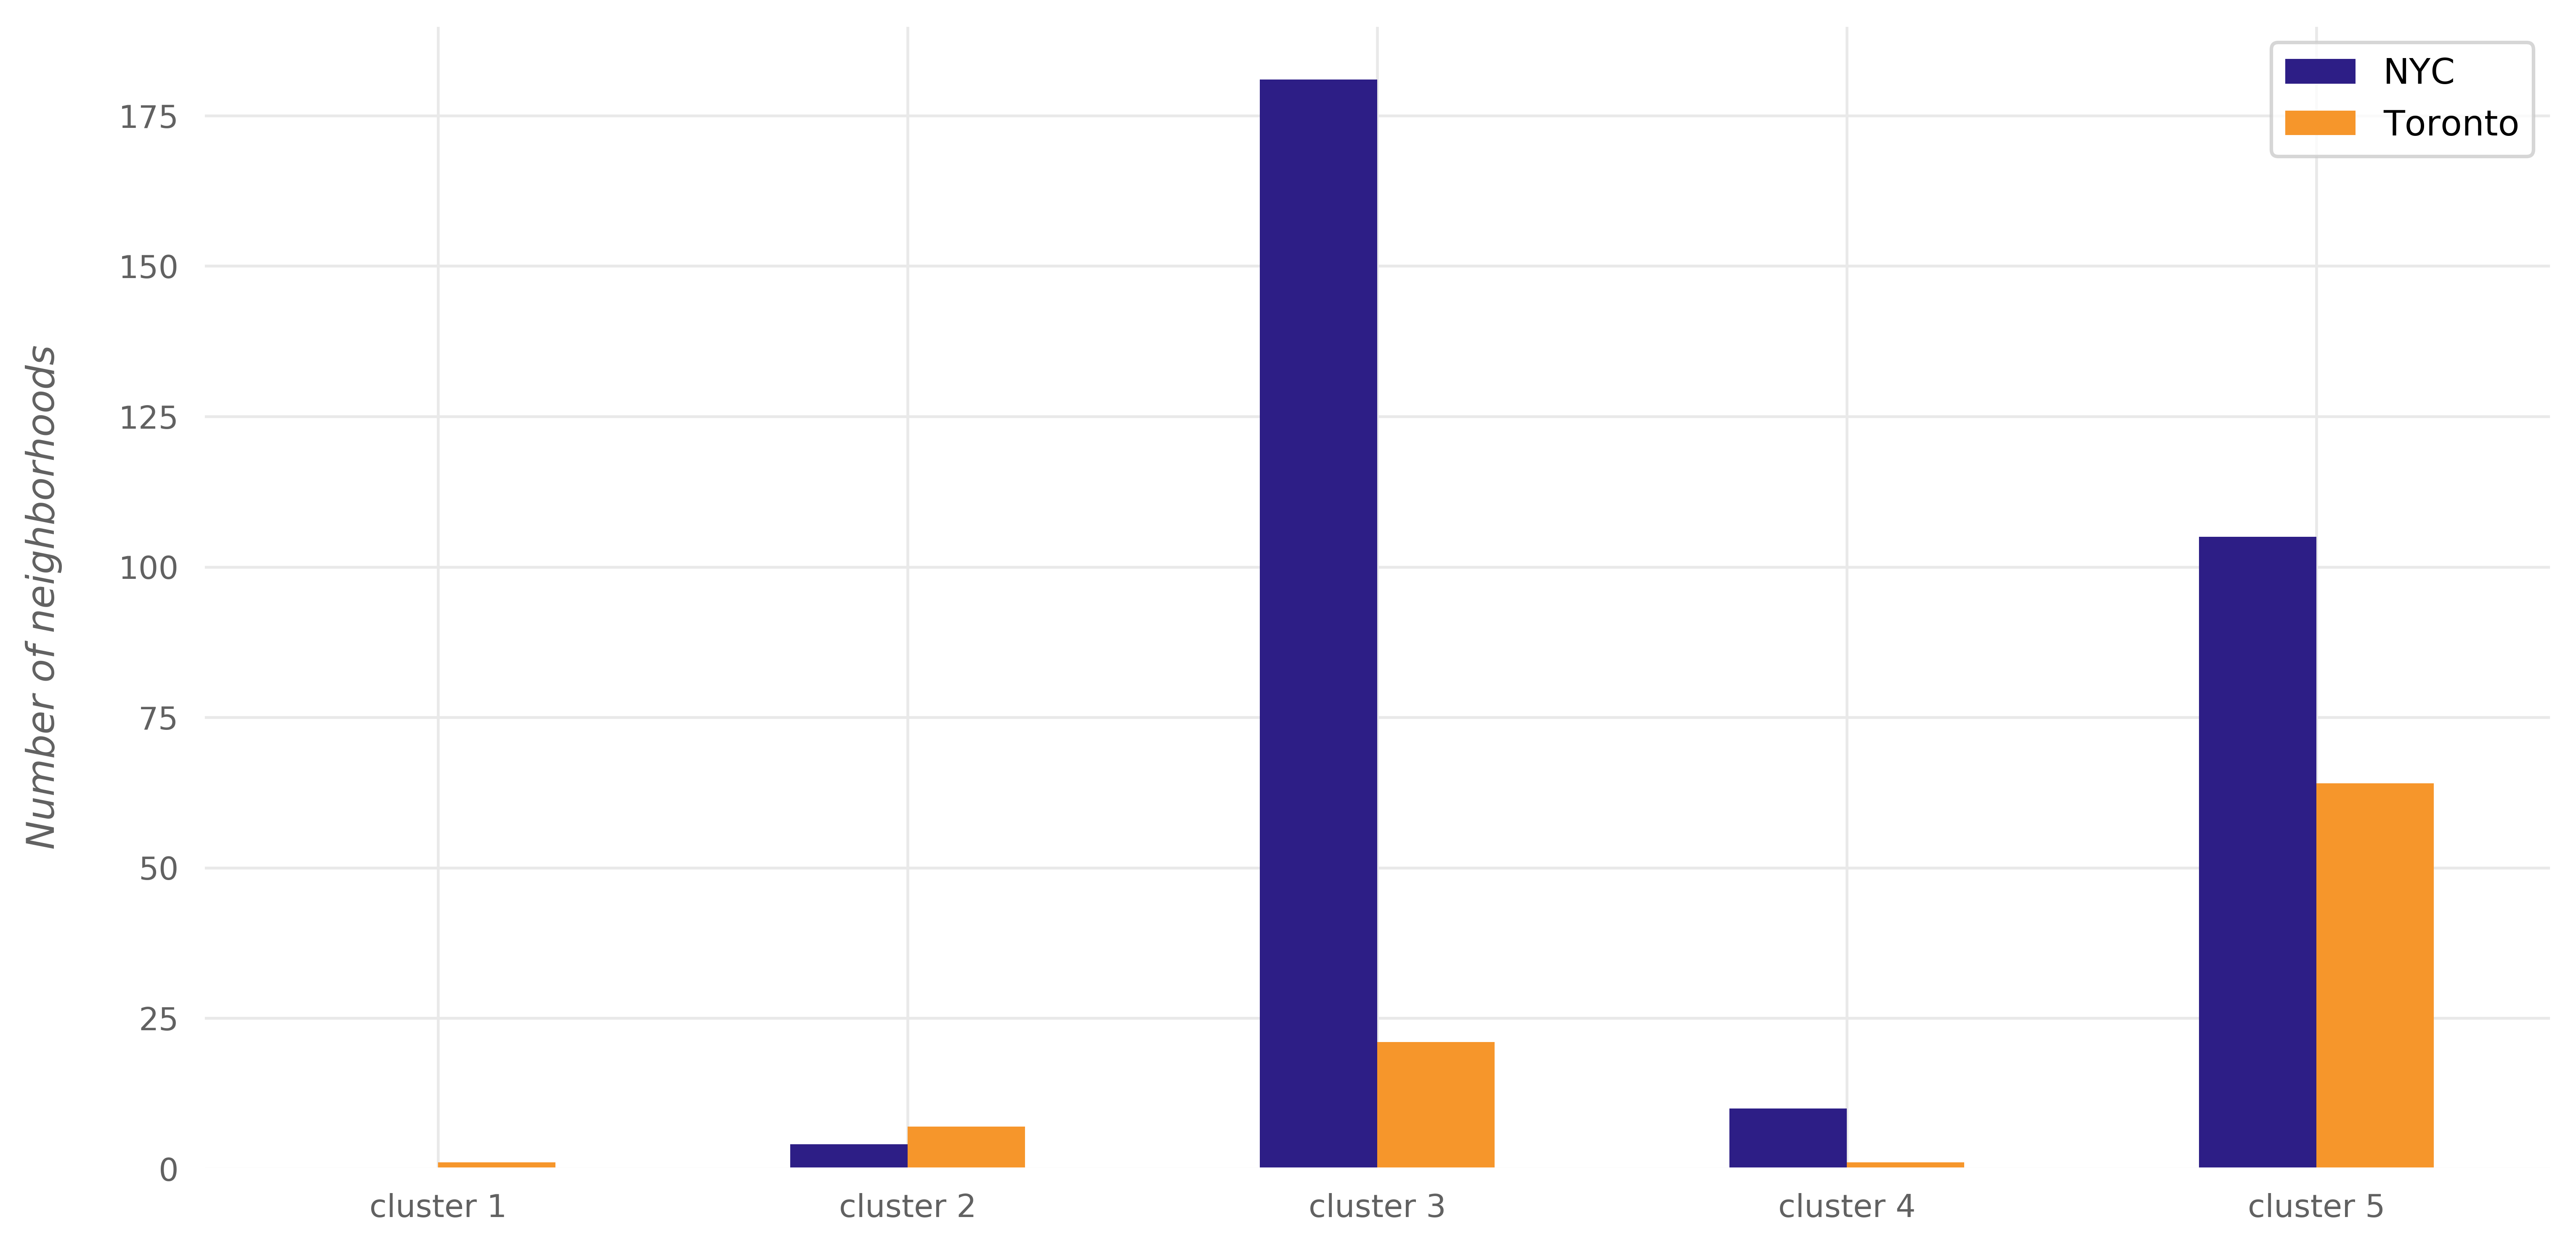

In [57]:
ind = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
city_c_df = pd.DataFrame({
    'NYC': [x[0] for x in n_counts],
    'Toronto': [x[1] for x in n_counts]
}, index = ind)

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
city_c_df.plot(kind='bar', color=['#2d1e86', '#f6962b'], rot=0, ax=ax)
plot_conf(ax, xlbl='', ylbl='Number of neighborhoods', t='')
fig.savefig('city-count.png', dpi=300)